In [1]:
from datetime import timedelta, datetime
import glob
from itertools import chain
import json
import os
import re

import numpy as np
import pandas as pd

from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from konlpy.tag import Twitter
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from pandas.plotting import register_matplotlib_converters
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
plt.rc('font', family='NanumGothic') # For Windows
print(plt.rcParams['font.family'])

'''
font_name = fm.FontProperties(fname=font_path, size=10).get_name()
plt.rc('font', family=font_name, size=12)
plt.rcParams["figure.figsize"] = (20, 10)
register_matplotlib_converters()

mpl.font_manager._rebuild()
mpl.pyplot.rc('font', family='NanumGothic')
[font.name for font in fm.fontManager.ttflist]
plt.rcParams['font.family'] = 'Malgun Gothic'
'''

['NanumGothic']


'\nfont_name = fm.FontProperties(fname=font_path, size=10).get_name()\nplt.rc(\'font\', family=font_name, size=12)\nplt.rcParams["figure.figsize"] = (20, 10)\nregister_matplotlib_converters()\n\nmpl.font_manager._rebuild()\nmpl.pyplot.rc(\'font\', family=\'NanumGothic\')\n[font.name for font in fm.fontManager.ttflist]\nplt.rcParams[\'font.family\'] = \'Malgun Gothic\'\n'

In [2]:
pd.options.mode.chained_assignment = None

In [3]:
genre_gn_all = pd.read_json('genre_gn_all.json', typ='series')
genre_gn_all.head()

GN0100       발라드
GN0101    세부장르전체
GN0102       '80
GN0103       '90
GN0104       '00
dtype: object

In [4]:
genre_gn_all = pd.DataFrame(genre_gn_all).reset_index().rename(columns={'index':'gnr_code',0:'gnr_name'})

In [5]:
(genre_gn_all.gnr_code.str[4:] == '00').sum()
#대분류코드 30개 소분류코드 224개


30

In [6]:
gnr_code = genre_gn_all[genre_gn_all.gnr_code.str[4:] == '00']
dtl_gnr_code = genre_gn_all[genre_gn_all.gnr_code.str[4:] != '00']
dtl_gnr_code.columns = ['dtl_gnr_code','dtl_gnr_name']

### 장르코드 트리

In [7]:
gnr_code = gnr_code.assign(join_code=gnr_code.gnr_code.str[:4])
dtl_gnr_code = dtl_gnr_code.assign(join_code=dtl_gnr_code.dtl_gnr_code.str[:4])

In [8]:
gnr_code_tree = pd.merge(gnr_code, dtl_gnr_code,on='join_code',how='left').drop(columns='join_code')

In [9]:
gnr_code_tree[gnr_code_tree.gnr_code == 'GN0900']

,gnr_code,gnr_name,dtl_gnr_code,dtl_gnr_name
48,GN0900,POP,GN0901,세부장르전체
49,GN0900,POP,GN0902,얼터너티브팝
50,GN0900,POP,GN0903,올디스
51,GN0900,POP,GN0904,월드팝
52,GN0900,POP,GN0905,'60-'70
53,GN0900,POP,GN0906,'80-'90
54,GN0900,POP,GN0907,'00
55,GN0900,POP,GN0908,'10-


In [10]:
song_meta = pd.read_json('song_meta.json')

In [11]:
song_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 707989 entries, 0 to 707988
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   song_gn_dtl_gnr_basket  707989 non-null  object
 1   issue_date              707989 non-null  int64 
 2   album_name              707985 non-null  object
 3   album_id                707989 non-null  int64 
 4   artist_id_basket        707989 non-null  object
 5   song_name               707989 non-null  object
 6   song_gn_gnr_basket      707989 non-null  object
 7   artist_name_basket      707989 non-null  object
 8   id                      707989 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 48.6+ MB


총 707,989곡의 메타 정보가 담겨 있으며 포함하는 값은 아래와 같습니다.
song_gn_dtl_gnr_basket : 상세 장르 코드
issue_date : 곡 발매 일자 (yyyymmdd)
album_name : 앨범 명
album_id : 앨범 아이디
artist_id_basket : 아티스트 아이디 (복수일 경우 띄어쓰기로 구분)
song_name : 곡 명
song_gn_gnr_basket : 대분류 장르코드
artist_name_basket : 아티스트 명 (복수일 경우 띄어쓰기로 구분)
id : 곡 아이디

In [12]:
song_gnr_map=song_meta.loc[:, ['id', 'song_gn_gnr_basket']]

In [13]:
#다중값 unnest하기
song_gnr_map_unnest = np.dstack((np.repeat(song_gnr_map.id.values,list(map(len,song_gnr_map.song_gn_gnr_basket))),
np.concatenate(song_gnr_map.song_gn_gnr_basket.values)))

In [14]:
song_gnr_map = pd.DataFrame(song_gnr_map_unnest[0], columns=song_gnr_map.columns)
song_gnr_map.columns = ['song_id','gnr_code']
song_gnr_map.song_id = song_gnr_map.song_id.astype('str')
del song_gnr_map_unnest

In [15]:
song_gnr_map

,song_id,gnr_code
0,0,GN0900
1,1,GN1600
2,2,GN0900
3,3,GN1100
4,4,GN1800
...,...,...
802854,707984,GN2000
802855,707985,GN0900
802856,707986,GN0100
802857,707987,GN1800


In [16]:
song_gnr_count = song_gnr_map.groupby('song_id')['gnr_code'].count().reset_index(name='mapping_gnr_cnt')

In [17]:
gnr_song_count = song_gnr_count.groupby('mapping_gnr_cnt')['song_id'].count().reset_index(name='mapping_song_cnt')
gnr_song_count['song_percent'] = round(gnr_song_count['mapping_song_cnt']/gnr_song_count['mapping_song_cnt'].sum()*100,2)
gnr_song_count

,mapping_gnr_cnt,mapping_song_cnt,song_percent
0,1,612806,86.69
1,2,92378,13.07
2,3,1694,0.24
3,4,48,0.01
4,5,1,0.00
5,6,3,0.00


In [18]:
song_gnr_count[song_gnr_count['mapping_gnr_cnt'] >= 2]
song_meta[song_meta['id']==456506]

,song_gn_dtl_gnr_basket,issue_date,album_name,album_id,artist_id_basket,song_name,song_gn_gnr_basket,artist_name_basket,id
456506,"[GN0403, GN0101, GN1501, GN1504]",20060731,오버 더 레인보우 OST,321962,[1928],그리운 건 어쩔 수 없어,"[GN0400, GN1500, GN0100]",[환희],456506


In [19]:
gnr_count = song_gnr_map['gnr_code'].value_counts().reset_index(name='song_cnt').rename(columns={'index':'gnr_code'})

In [20]:
gnr_count = pd.merge(gnr_count,gnr_code[['gnr_code','gnr_name']],how='left',on='gnr_code')
gnr_count['gnr_code_name'] = gnr_count['gnr_code'] + '(' + gnr_count['gnr_name'] + ')'
gnr_count.dropna(inplace=True)

Text(0, 0.5, '곡 수')

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 51109 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 47476 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 48324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 47588 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 54609 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matp

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 47448 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 53076 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 47197 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 47700 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 53448 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 51068 missing from current

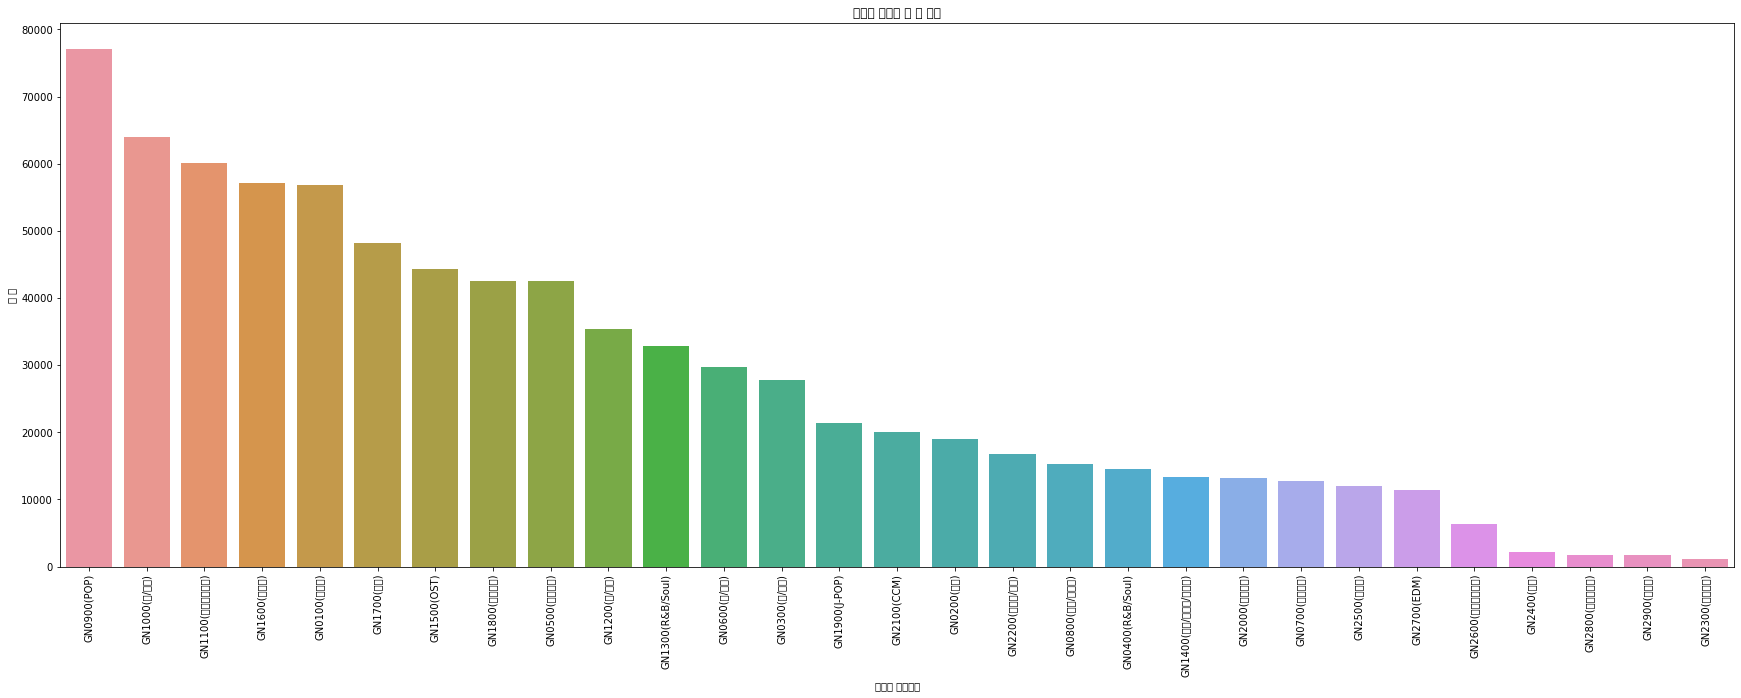

In [21]:
plt.figure(figsize=(30,10))
plt.xticks(rotation=90)
gnr_code_name_plot = sns.barplot(x=gnr_count['gnr_code_name'],y=gnr_count['song_cnt'])
gnr_code_name_plot.set_title('장르별 매핑된 곡 수 분포')
gnr_code_name_plot.set_xlabel('대분류 장르코드')
gnr_code_name_plot.set_ylabel('곡 수')

In [22]:
song_issue_date = song_meta[['id','issue_date']]
song_issue_date['issue_date'] = song_issue_date['issue_date'].astype(str)

In [23]:
song_issue_date['issue_year'] = song_issue_date['issue_date'].str[:4]
song_issue_date.rename(columns={'id':'song_id'},inplace=True)
song_issue_date.song_id = song_issue_date.song_id.astype(str)

In [24]:
#1990년이상으로 필터링
song_issue_date_filter = song_issue_date[song_issue_date['issue_year'] >= '1990']

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 50672 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 48324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 48156 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 47588 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 44257 missing from c

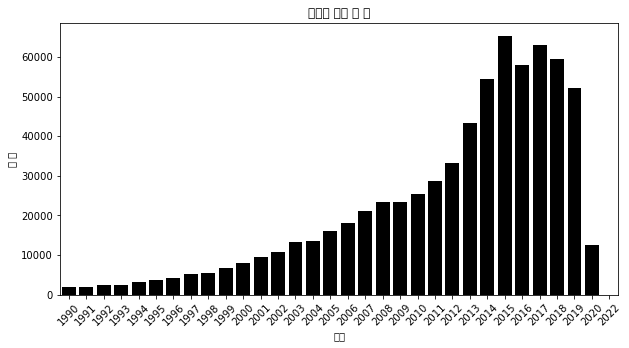

In [25]:
#발매년도 별 곡 수 count 테이블 생성 : issue_year_song_cnt
issue_year_song_cnt = song_issue_date_filter.groupby('issue_year')['song_id'].count().reset_index(name='song_cnt')
plt.figure(figsize=(10,5))
issue_year_song_cnt_plot = sns.barplot(x='issue_year',y='song_cnt',data=issue_year_song_cnt,color='#000000')
issue_year_song_cnt_plot.set_title('연도별 발매 곡 수')
issue_year_song_cnt_plot.set_xlabel('연도')
issue_year_song_cnt_plot.set_ylabel('곡 수')
plt.xticks(rotation=45);

### train

In [26]:
train = pd.read_json('train.json')

#### id와 수록곡 추출

In [27]:
%%time
plylst_song_map = train[['id','songs']]
#songs unnest
plylst_song_map_unnest = np.dstack((
np.repeat(plylst_song_map.id.values,list(map(len,plylst_song_map['songs']))),
np.concatenate(plylst_song_map.songs)))

plylst_song_map = pd.DataFrame(plylst_song_map_unnest[0],columns=plylst_song_map.columns)
plylst_song_map['id'] = plylst_song_map['id'].astype(str)
plylst_song_map['songs'] = plylst_song_map['songs'].astype(str)
del plylst_song_map_unnest

Wall time: 29.5 s


#### id와 tag 추출

In [28]:
%%time
plylst_tag_map = train[['id','tags']]
plylst_tag_map_unnest = np.dstack((np.repeat(plylst_tag_map['id'],list(map(len,plylst_tag_map['tags']))),
np.concatenate(plylst_tag_map['tags'])))

plylst_tag_map = pd.DataFrame(plylst_tag_map_unnest[0],columns=plylst_tag_map.columns)
plylst_tag_map['id'] = plylst_tag_map['id'].astype(str)
del plylst_tag_map_unnest

Wall time: 3.49 s


In [29]:
plylst_tag_map.head()

,id,tags
0,61281,락
1,10532,추억
2,10532,회상
3,76951,까페
4,76951,잔잔한


In [30]:
#유니크 곡과 태그
print('곡 수:', plylst_song_map.songs.nunique())
print('태그 수 : %s' %plylst_tag_map.tags.nunique())

곡 수: 615142
태그 수 : 29160


### 플레이리스트별 곡/태그/장르 수

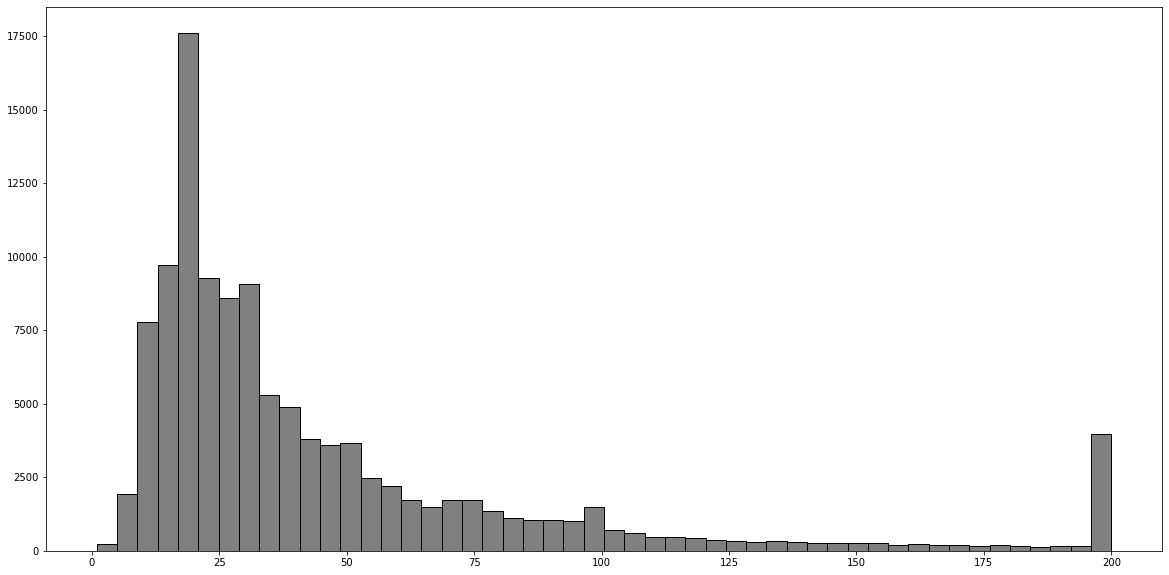

In [31]:
plylst_song_cnt = plylst_song_map.groupby('id').count()
plt.figure(figsize=(20,10))
plt.hist(plylst_song_cnt,bins=50,color='grey',edgecolor='#000000');

In [32]:
plylst_song_cnt.describe().T

,count,mean,std,min,25%,50%,75%,max
songs,115071.0,45.935735,43.950335,1.0,19.0,30.0,54.0,200.0


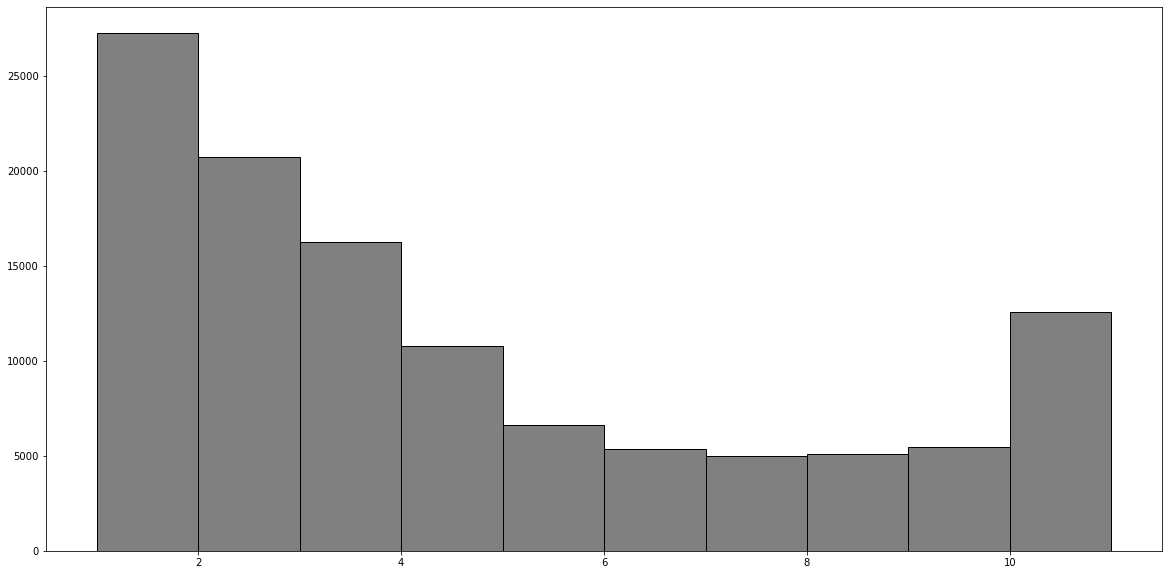

In [33]:
#태그
plylst_tags_cnt = plylst_tag_map.groupby('id').count()
plt.figure(figsize=(20,10))
plt.hist(plylst_tags_cnt,bins=10,color='grey',edgecolor='#000000');

In [34]:
plylst_tags_cnt.describe().T

,count,mean,std,min,25%,50%,75%,max
tags,115071.0,4.139453,3.072261,1.0,2.0,3.0,6.0,11.0


In [35]:
plylst_song_map
song_gnr_map

,song_id,gnr_code
0,0,GN0900
1,1,GN1600
2,2,GN0900
3,3,GN1100
4,4,GN1800
...,...,...
802854,707984,GN2000
802855,707985,GN0900
802856,707986,GN0100
802857,707987,GN1800


In [36]:
plylst_song_map
plylst_song_gnr_map = pd.merge(plylst_song_map,song_gnr_map,how='left',left_on='songs',right_on='song_id')
plylst_song_gnr_cnt = plylst_song_gnr_map.groupby('id')['gnr_code'].nunique().reset_index()


,gnr_code
count,115071.000000
mean,6.550912
std,3.620771
min,0.000000
25%,4.000000
50%,6.000000
75%,9.000000
max,26.000000


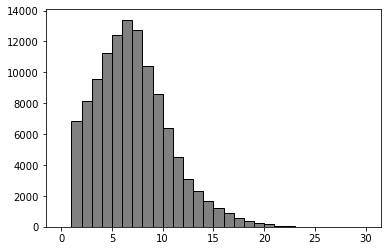

In [37]:
#장르 수별 플레이리스트 개수
plt.hist(plylst_song_gnr_cnt['gnr_code'],range(0,31),color='grey',edgecolor='black');
plylst_song_gnr_cnt.describe()
#플레이리스트들은 평균 6개의 장르를 가지고 있다

### 중복 수록곡 비중

In [38]:
song_plylst_cnt = plylst_song_map.groupby('songs')['id'].count().reset_index(name='mapping_plylst_cnt')


In [39]:
song_plylst_cnt = song_plylst_cnt.assign(mapping_plylst_cnt_category = pd.cut(song_plylst_cnt['mapping_plylst_cnt'],[0,1,np.inf],labels=['단일수록','중복수록']))

In [40]:
song_plylst_mapping_division = song_plylst_cnt.groupby('mapping_plylst_cnt_category')['songs'].count().reset_index()
song_plylst_mapping_division['mapping_plylst_cnt_cat_percent'] = round(song_plylst_mapping_division['songs'] / song_plylst_mapping_division['songs'].sum() *100,2)
song_plylst_mapping_division

,mapping_plylst_cnt_category,songs,mapping_plylst_cnt_cat_percent
0,단일수록,299028,48.61
1,중복수록,316114,51.39


In [41]:
song_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 707989 entries, 0 to 707988
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   song_gn_dtl_gnr_basket  707989 non-null  object
 1   issue_date              707989 non-null  int64 
 2   album_name              707985 non-null  object
 3   album_id                707989 non-null  int64 
 4   artist_id_basket        707989 non-null  object
 5   song_name               707989 non-null  object
 6   song_gn_gnr_basket      707989 non-null  object
 7   artist_name_basket      707989 non-null  object
 8   id                      707989 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 48.6+ MB


In [42]:
duplicate_song_top30 = song_plylst_cnt[song_plylst_cnt['mapping_plylst_cnt_category'] == '중복수록'].sort_values(by='mapping_plylst_cnt',ascending=False).head(30)
song_meta['id'] = song_meta['id'].astype(str)
duplicate_song_chart = pd.merge(song_meta[['id','song_name','artist_name_basket']],duplicate_song_top30, how='right',left_on='id',right_on='songs')

In [43]:
duplicate_song_chart[['id','song_name','artist_name_basket','mapping_plylst_cnt']].rename(columns={'id':'곡 아이디','song_name':'곡 명','artist_name_basket':'가수명','mapping_plylst_cnt':'수록 횟 수'})

,곡 아이디,곡 명,가수명,수록 횟 수
0,144663,밤편지,[아이유],2175
1,116573,안아줘,[정준일],2121
2,357367,비,[폴킴],1981
3,366786,가끔 미치도록 네가 안고 싶어질 때가 있어,[가을방학],1919
4,654757,눈의 꽃,[박효신],1647
5,133143,"그대와 나, 설레임 (Feat. 소울맨)",[어쿠스틱 콜라보],1633
6,349492,어떤이별,[임승부],1599
7,675115,야생화,[박효신],1598
8,463173,비가 내렸어 (Vocal by 스티브언니),[업라이트 (Upright)],1544
9,42155,벙어리,[홍아],1540


In [44]:
single_song = song_plylst_cnt[song_plylst_cnt['mapping_plylst_cnt_category'] == '단일수록']
single_song_artist = pd.merge(single_song, song_meta[['id', 'song_name', 'artist_name_basket']], how='left', left_on = 'songs',right_on='id')
single_song_gnr = pd.merge(single_song,song_gnr_map,how='left',left_on = 'songs', right_on = 'song_id')

In [45]:
single_song_gnr_cnt = single_song_gnr.groupby('gnr_code').count()[['song_id']].sort_values(by='song_id',ascending=False).reset_index()
pd.merge(single_song_gnr_cnt,gnr_code,how='left',on='gnr_code')[['gnr_code','song_id','gnr_name']].rename(columns={'gnr_code':'장르코드','song_id':'수록 곡 수','gnr_name':'장르명'})

,장르코드,수록 곡 수,장르명
0,GN1600,32841,클래식
1,GN0900,30987,POP
2,GN1000,30028,록/메탈
3,GN1100,25725,일렉트로니카
4,GN1700,23158,재즈
5,GN1800,19370,뉴에이지
6,GN1500,16855,OST
7,GN1200,15054,랩/힙합
8,GN0100,14575,발라드
9,GN1300,13136,R&B/Soul


In [46]:
tag_plylst_cnt = plylst_tag_map.groupby('tags').count().reset_index().rename(columns={'id':'mapping_plylst_cnt'})
tag_plylst_cnt = tag_plylst_cnt.assign(mapping_plylst_cnt_category = pd.cut(tag_plylst_cnt['mapping_plylst_cnt'], [0,1,np.inf],labels=['단일태그','중복태그']))
tag_plylst_mapping_division = tag_plylst_cnt.groupby('mapping_plylst_cnt_category').count()
tag_plylst_mapping_division['태그 비율'] = round(tag_plylst_mapping_division['mapping_plylst_cnt'] / tag_plylst_mapping_division['mapping_plylst_cnt'].sum()*100,2)
tag_plylst_mapping_division.rename(columns={'tags':'태그 수'},inplace=True)
tag_plylst_mapping_division.drop(columns='mapping_plylst_cnt',inplace=True)

In [47]:
plylst_title = train[['id','plylst_title']]
plylst_id_cnt = plylst_title.groupby('plylst_title').count().reset_index().rename(columns={'id':'mapping_plylst_cnt'})
plylst_id_cnt['mapping_plylst_cnt_category'] = pd.cut(plylst_id_cnt['mapping_plylst_cnt'],[0,1,np.inf],labels=['단일플리','중복플리'])
plylst_id_cnt_division = pd.DataFrame(plylst_id_cnt.groupby('mapping_plylst_cnt_category')['plylst_title'].count())
plylst_id_cnt_division['태그 비율'] = round(plylst_id_cnt_division['plylst_title'] / plylst_id_cnt_division['plylst_title'].sum()*100,2)
plylst_id_cnt_division

,plylst_title,태그 비율
mapping_plylst_cnt_category,,
단일플리,108214,97.9
중복플리,2317,2.1


In [48]:
temp = plylst_id_cnt[plylst_id_cnt['mapping_plylst_cnt_category']=='중복플리']
duplicate_plylst = pd.merge(temp,train,how='left',on='plylst_title')[['plylst_title','tags','id','songs']]
duplicate_plylst_unnest = np.dstack((np.repeat(duplicate_plylst['plylst_title'],list(map(len,duplicate_plylst['songs']))),
np.concatenate(duplicate_plylst['songs'])))
duplicate_plylst = pd.DataFrame(duplicate_plylst_unnest[0])
duplicate_plylst.columns = ['plylst_title','id']
duplicate_plylst['id'] = duplicate_plylst['id'].astype(str)

In [49]:
duplicate_plylst.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 352479 entries, 0 to 352478
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   plylst_title  352479 non-null  object
 1   id            352479 non-null  object
dtypes: object(2)
memory usage: 5.4+ MB


In [50]:
pd.merge(duplicate_plylst,song_meta[['id','song_name']],how = 'left',on='id')

,plylst_title,id,song_name
0,!!!!,340679,그대와 같아
1,!!!!,693847,Hocus-Pocus (Feat. 효빈)
2,!!!!,25892,On My Way (Feat. Zion.T)
3,!!!!,24221,Click Me (Feat. Dok2)
4,!!!!,391778,Let Me Love U
...,...,...,...
352474,＃＃90년대발라드,419993,소주한잔
352475,＃＃90년대발라드,43326,더데이 (The Day)
352476,＃＃90년대발라드,306611,본능적으로 (Feat. Swings)
352477,＃＃90년대발라드,194385,그대이길 바래요 (With 케이윌)


### Test Val json 

In [67]:
test = pd.read_json('test.json')
val = pd.read_json('val.json')

In [71]:
train

,tags,id,plylst_title,songs,like_cnt,updt_date
0,[락],61281,여행같은 음악,"[525514, 129701, 383374, 562083, 297861, 13954...",71,2013-12-19 18:36:19.000
1,"[추억, 회상]",10532,요즘 너 말야,"[432406, 675945, 497066, 120377, 389529, 24427...",1,2014-12-02 16:19:42.000
2,"[까페, 잔잔한]",76951,"편하게, 잔잔하게 들을 수 있는 곡.-","[83116, 276692, 166267, 186301, 354465, 256598...",17,2017-08-28 07:09:34.000
3,"[연말, 눈오는날, 캐럴, 분위기, 따듯한, 크리스마스캐럴, 겨울노래, 크리스마스,...",147456,크리스마스 분위기에 흠뻑 취하고 싶을때,"[394031, 195524, 540149, 287984, 440773, 10033...",33,2019-12-05 15:15:18.000
4,[댄스],27616,추억의 노래 ㅋ,"[159327, 553610, 5130, 645103, 294435, 100657,...",9,2011-10-25 13:54:56.000
...,...,...,...,...,...,...
115066,"[록메탈, 밴드사운드, 록, 락메탈, 메탈, 락, extreme]",120325,METAL E'SM #2,"[429629, 441511, 612106, 516359, 691768, 38714...",3,2020-04-17 04:31:11.000
115067,[일렉],106976,빠른 리스너를 위한 따끈따끈한 최신 인기 EDM 모음!,"[321330, 216057, 534472, 240306, 331098, 23288...",13,2015-12-24 17:23:19.000
115068,"[담시, 가족, 눈물, 그리움, 주인공, 나의_이야기, 사랑, 친구]",11343,#1. 눈물이 앞을 가리는 나의_이야기,"[50512, 249024, 250608, 371171, 229942, 694943...",4,2019-08-16 20:59:22.000
115069,"[잔잔한, 버스, 퇴근버스, Pop, 풍경, 퇴근길]",131982,퇴근 버스에서 편히 들으면서 하루를 마무리하기에 좋은 POP,"[533534, 608114, 343608, 417140, 609009, 30217...",4,2019-10-25 23:40:42.000
